# CycleGAN: Unpaired Image-to-Image Translation

## 0. Some setup before we begin...

In this folder, please run the following commands to create empty folders for logging:

```
mkdir checkpoints_cyclegan
mkdir samples_cyclegan
```

Also, make sure the unzipped dataset folder ```summer2winter_yosemite``` is in the same folder as this file.

## 1. Load and Visualize the Data 

In [1]:
import os
import torch
from torch.utils.data import DataLoader
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import warnings

%matplotlib inline

# Some matplotlib settings
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams["axes.grid"] = False
plt.rcParams["xtick.major.bottom"] = False
plt.rcParams["ytick.major.left"] = False

# Device Settings
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Some training settings:
batch_size = 16
num_workers = 0

The dataset can be downloaded from the following [Link](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip).

Move the ```summer2winter_yosemite``` folder into the git repo.

### Define function to generate train and test dataloaders

The following function returns train and test dataloaders, which we will use to visualize the data and train the model

In [2]:
def get_data_loaders(image_type, image_dir='summer2winter_yosemite', transform=None, batch_size=16, num_workers=0):
    
    # get training and test directories
    image_type_test = "test_{}".format(image_type)
    train_path = os.path.join(image_dir, image_type)
    test_path = os.path.join(image_dir, image_type_test)

    # define datasets using ImageFolder
    train_dataset = datasets.ImageFolder(train_path, transform)
    test_dataset = datasets.ImageFolder(test_path, transform)

    # create and return DataLoaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return train_loader, test_loader

Now we can call the functions to get two sets of dataloaders. 

But first, we must define a image transformation function to transform the images from PIL format to Tensor format.

We also normalize the image using standard mean and variances

transforms.Compose() takes a list of transformations and calls them in sequence. 

In [3]:
image_size = 256
transformations = transforms.Compose([transforms.Resize(image_size), transforms.ToTensor(), 
                                      transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])])

summer_dataloader, test_summer_dataloader = get_data_loaders(image_type='summer', transform=transformations, 
                                                            batch_size=batch_size, num_workers=num_workers)
winter_dataloader, test_winter_dataloader = get_data_loaders(image_type='winter', transform=transformations,
                                                            batch_size=batch_size, num_workers=num_workers)

Dataset created by ```datasets.ImageFolder``` return two values: 

1. Image
2. corresponding label.

When we wrap a dataloader around the dataset, this becomes a batch of images, and the corresponding labels. 

In our case, we are not interested in the labels (they are all 0). Thus, to visualize the data, we only save the first term of the returned values. To iterate just one batch of the dataset, we wrap the dataloader as an iterable and call one iteration.


### Visualize the data 

We define an inverse transform that changes a tensor back to a PIL Image. First, we "unnormalize" the tensor by taking the inverse of the normalization function from above. Then, we can call ```transforms.ToPILImage()``` which will convert the tensor to a PIL Image

In [4]:
def get_pil_img_from_tensor(img_tensor):
    inverse_transform = transforms.Compose([transforms.Normalize(mean=[-1, -1, -1], std=[1/0.5, 1/0.5, 1/0.5]), 
                                            transforms.ToPILImage()])
    return inverse_transform(img_tensor)

def show_img(pil_img):
    plt.imshow(pil_img)

In [5]:
batch_summer_imgs, _ = next(iter(summer_dataloader))
batch_winter_imgs, _ = next(iter(winter_dataloader))

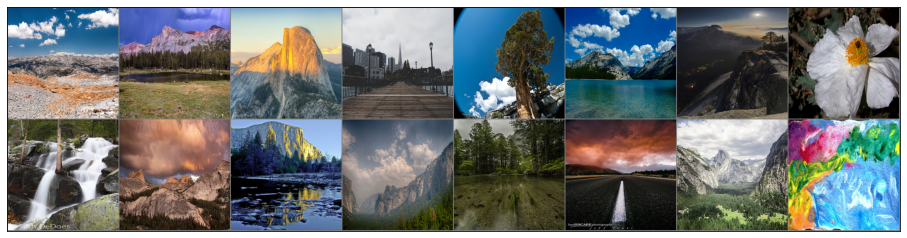

In [6]:
show_img(get_pil_img_from_tensor(torchvision.utils.make_grid(batch_summer_imgs)))

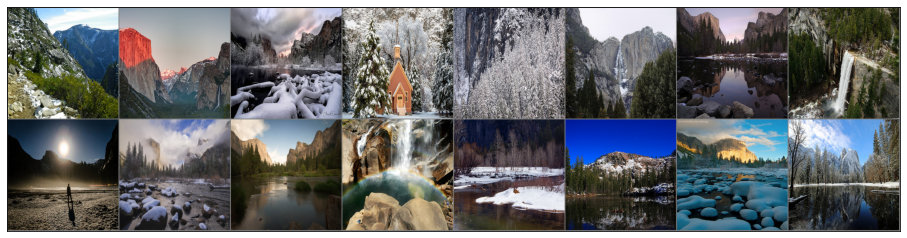

In [7]:
show_img(get_pil_img_from_tensor(torchvision.utils.make_grid(batch_winter_imgs)))

## 2. Define the Model 

A CycleGAN is composed of two discriminators and two generators.

### Discriminators
The discriminators, $D_X$ and $D_Y$, in this CycleGAN are convolutional neural networks that see an image and attempt to classify it as real or fake. In this case, real is indicated by an output close to 1 and fake as close to 0. The discriminators have the following architecture:

<img src='imgs/discriminator_layers.png' width=80% />

### A function that creates a general convolution layer 

In [8]:
import torch.nn as nn
import torch.nn.functional as F

# helper conv function. Note that DEFAULT stride = 2
def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a convolutional layer, with optional batch normalization.
    """
    layers = []
    conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, 
                           kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
    
    layers.append(conv_layer)

    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### The Discriminator

Let's create the discriminator!

> **Exercise**: Create a discriminator model using the `conv` function above. Refer to the image above for what the network should look like!

In [9]:
class Discriminator(nn.Module):
    
    def __init__(self, conv_dim=64):
        super(Discriminator, self).__init__()

        # Define all convolutional layers
        # Should accept an RGB image as input and output a single value

        # Convolutional layers, increasing in depth
        # first layer has *no* batchnorm
        self.conv1 = conv(3, conv_dim, 3, batch_norm=False) # x, y = 64, depth 64
        self.conv2 = conv(conv_dim, conv_dim*2, 3) # (32, 32, 128)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 3) # (16, 16, 256)
        self.conv4 = conv(conv_dim*4, conv_dim*8, 3) # (8, 8, 512)
        
        # Classification layer
        self.conv5 = conv(conv_dim*8, 1, 4, stride=1, batch_norm=False)

    def forward(self, x):
        # relu applied to all conv layers but last
        out = F.relu(self.conv1(x))      #결과 size [16, 64, 64, 64]
        out = F.relu(self.conv2(out))    #[16, 128, 32, 32]
        out = F.relu(self.conv3(out))    #[16, 256, 16, 16]
        out = F.relu(self.conv4(out))    #[16, 512, 8, 8]
        out = self.conv5(out)            #[16, 1, 7, 7]
        return out


### The Generator

<img src='imgs/cyclegan_generator_ex.png' width=90% />


### Residual Block

<img src='imgs/resnet_block.png' width=40%/>

In [ ]:
# residual block class
class ResidualBlock(nn.Module):

    def __init__(self, conv_dim):
        super(ResidualBlock, self).__init__()
        # conv_dim = number of inputs
        
        # define two convolutional layers + batch normalization that will act as our residual function, F(x)
        # layers should have the same shape input as output; I suggest a kernel_size of 3
        
        self.conv_layer1 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                                kernel_size=3, stride=1, padding=1, batch_norm=True)
        
        self.conv_layer2 = conv(in_channels=conv_dim, out_channels=conv_dim, 
                               kernel_size=3, stride=1, padding=1, batch_norm=True)
        
    def forward(self, x):
        out_1 = F.relu(self.conv_layer1(x))
        out_2 = x + self.conv_layer2(out_1)
        return F.relu(out_2)

### Deconv Layer 

In [10]:
def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
    """Creates a transpose convolutional layer, with optional batch normalization.
    """
    layers = []
    # append transpose conv layer
    layers.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False))
    # optional batch norm layer
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
    return nn.Sequential(*layers)

### The Generator

Use:
* 3 conv layers,
* Resnet layers (given)
* 3 transpose conv layers

Output shape of transpose conv can be calculated by the following formula:

```
output_size = strides * (input_size-1) + kernel_size - 2*padding
```

select the correct input dims, output dims and kernel size! (Default stride = 2, default padding = 1)

In [11]:
class CycleGenerator(nn.Module):
    
    def __init__(self, conv_dim=64, n_res_blocks=6):
        super(CycleGenerator, self).__init__()

        # Encoder 
        
        self.conv1 = conv(3, conv_dim, 3)
        self.conv2 = conv(conv_dim, conv_dim*2, 3)
        self.conv3 = conv(conv_dim*2, conv_dim*4, 3)

        # Resnet part
        res_layers = []
        for layer in range(n_res_blocks):
            res_layers.append(ResidualBlock(conv_dim*4))
        
        self.res_blocks = nn.Sequential(*res_layers)

        # 3. Decoder
        self.deconv1 = deconv(conv_dim*4, conv_dim*2, 4)
        self.deconv2 = deconv(conv_dim*2, conv_dim, 4)
        self.deconv3 = deconv(conv_dim, 3, 4, batch_norm=False)  # no batch norm on last layer
        
    def forward(self, x):
        """Given an image x, returns a transformed image."""
        # define feedforward behavior, applying activations as necessary

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = self.res_blocks(out)

        out = F.relu(self.deconv1(out))
        out = F.relu(self.deconv2(out))
        out = F.tanh(self.deconv3(out))           # tanh applied to last layer
        return out

### Model Creator 

In [12]:
def create_model(g_conv_dim=64, d_conv_dim=64, n_res_blocks=6, device='cuda'):
    
    G_XtoY = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    G_YtoX = CycleGenerator(conv_dim=g_conv_dim, n_res_blocks=n_res_blocks)
    D_X = Discriminator(conv_dim=d_conv_dim)
    D_Y = Discriminator(conv_dim=d_conv_dim)

    # Cast to appropriate device. 
    G_XtoY.to(device)
    G_YtoX.to(device)
    D_X.to(device)
    D_Y.to(device)
    print('Models loaded on {}'.format(device))

    return G_XtoY, G_YtoX, D_X, D_Y

In [13]:
G_XtoY, G_YtoX, D_X, D_Y = create_model(device=device)

Models loaded on cuda


#### At this point, you can open a terminal on the server and run ```nvidia-smi```. On the first GPU, you will see that some memory has been allocated for your model (~1GB). 

If you want to skip training and just visualize samples, skip to Section 6

## 3. Loss functions 

We can use the ```MSELoss()``` and ```L1Loss()``` defined in ```torch.nn``` for our loss functions.

In [14]:
def real_mse_loss(D_out):
    return torch.mean((D_out-1)**2)

def fake_mse_loss(D_out):
    return torch.mean(D_out**2)

def cycle_consistency_loss(real_im, reconstructed_im, lambda_weight):
    reconstr_loss = torch.mean(torch.abs(real_im - reconstructed_im))
    return lambda_weight*reconstr_loss

## 4. Optimizers 

- We will use Adam with a initial learning rate of ```lr=0.0002```. 

- In PyTorch, we pass the model's parameters into the optimizer. The model's parameters can be obtained by calling ```model.parameters()```. 

- When we want to optimize the parameters of two models with one optimizer, we can simply concatenate the list of the two models' parameters and pass that into the optimizer 

In [15]:
import torch.optim as optim

# Hyperparameters for Adam optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_x_optimizer = optim.Adam(params=D_X.parameters(), lr=lr, betas=[beta1, beta2])
d_y_optimizer = optim.Adam(params=D_Y.parameters(), lr=lr, betas=[beta1, beta2])

generator_params = list(G_XtoY.parameters()) + list(G_YtoX.parameters())
g_optimizer = optim.Adam(params=generator_params, lr=lr, betas=[beta1, beta2])

## 5. Training 

### Training Loop 

Skip this part if you want to skip directly to visualizing the results with a pretrained network.

Training takes around **80 minutes** on a single **NVIDIA 2080Ti** GPU (CUDA 10.2) for 6000 iterations. It will use up around **7GB** of VRAM

In [16]:
import time
from helpers import save_samples, checkpoint

In [17]:
def training_loop(dataloader_X, dataloader_Y, test_dataloader_X, test_dataloader_Y, 
                  n_epochs=1000):
    
    since = time.time()
    print_every=100
    sample_every=100
    
    losses = []      # keep track of losses over time

    
    test_iter_X = iter(test_dataloader_X)
    test_iter_Y = iter(test_dataloader_Y)

    # Get some fixed data from domains X and Y for sampling. These are images that are held
    # constant throughout training, that allow us to inspect the model's performance.
    fixed_X = test_iter_X.next()[0]
    fixed_Y = test_iter_Y.next()[0]

    # batches per epoch
    iter_X = iter(dataloader_X)
    iter_Y = iter(dataloader_Y)
    batches_per_epoch = min(len(iter_X), len(iter_Y))

    for epoch in range(1, n_epochs+1):

        # Reset iterators for each epoch
        if epoch % batches_per_epoch == 0:
            iter_X = iter(dataloader_X)
            iter_Y = iter(dataloader_Y)

        images_X, _ = iter_X.next()
        images_Y, _ = iter_Y.next()
        
        # move images to device
        images_X = images_X.to(device)
        images_Y = images_Y.to(device)

        # ============================================
        #            TRAIN THE DISCRIMINATORS
        # ============================================

        """D_X """ 
        
        d_x_optimizer.zero_grad()

        # Train with real X images
        
        out_x = D_X(images_X)
        D_X_real_loss = real_mse_loss(out_x)
        
        # Train with fake X images
        fake_X = G_YtoX(images_Y)
        out_x = D_X(fake_X.detach())
        D_X_fake_loss = fake_mse_loss(out_x)
        
        d_x_loss = D_X_real_loss + D_X_fake_loss
        d_x_loss.backward()
        d_x_optimizer.step()
        
        """D_Y """ 
        
        d_y_optimizer.zero_grad()
        
        # Train with real Y images
        out_y = D_Y(images_Y)
        D_Y_real_loss = real_mse_loss(out_y)
        
        # Train with fake Y images
        fake_Y = G_XtoY(images_X)
        out_y = D_Y(fake_Y.detach())
        D_Y_fake_loss = fake_mse_loss(out_y)

        d_y_loss = D_Y_real_loss + D_Y_fake_loss
        d_y_loss.backward()
        d_y_optimizer.step()


        # =========================================
        #            TRAIN THE GENERATORS
        # =========================================

        """G : G_XtoY + G_YtoX """ 
        

        g_optimizer.zero_grad()
        
        fake_X = G_YtoX(images_Y)
        out_x = D_X(fake_X)
        g_YtoX_loss = real_mse_loss(out_x)

        fake_Y = G_XtoY(images_X)
        out_y = D_Y(fake_Y)
        g_XtoY_loss = real_mse_loss(out_y)

        reconstructed_X = G_YtoX(fake_Y)
        reconstructed_x_loss = cycle_consistency_loss(images_X, reconstructed_X, lambda_weight=10)
        
        reconstructed_Y = G_XtoY(fake_X)
        reconstructed_y_loss = cycle_consistency_loss(images_Y, reconstructed_Y, lambda_weight=10)

        g_total_loss = g_YtoX_loss + g_XtoY_loss + reconstructed_y_loss + reconstructed_x_loss
        g_total_loss.backward()
        g_optimizer.step()

        # Print
        if epoch % print_every == 0:
            # append real and fake discriminator losses and the generator loss
            losses.append((d_x_loss.item(), d_y_loss.item(), g_total_loss.item()))
            time_elapsed = time.time() - since
            print('Epoch [{:5d}/{:5d}] | d_X_loss: {:6.4f} | d_Y_loss: {:6.4f} | g_total_loss: {:6.4f} time : {:.0f}m {:.0f}s'.format(
                    epoch, n_epochs, d_x_loss.item(), d_y_loss.item(), g_total_loss.item(),time_elapsed // 60, time_elapsed % 60))

        
        if epoch % sample_every == 0:
            G_YtoX.eval() # set generators to eval mode for sample generation
            G_XtoY.eval()
            save_samples(epoch, fixed_Y, fixed_X, G_YtoX, G_XtoY, batch_size=16, sample_dir='samples_cyclegan')
            G_YtoX.train()
            G_XtoY.train()

        checkpoint_every=1
        if epoch % checkpoint_every == 0:
            checkpoint(epoch, G_XtoY, G_YtoX, D_X, D_Y)

    return losses

In [18]:
n_epochs = 6000 # keep this small when testing if a model first works

losses = training_loop(summer_dataloader, winter_dataloader, test_summer_dataloader, test_winter_dataloader, n_epochs=n_epochs)

Epoch [  100/ 6000] | d_X_loss: 0.3231 | d_Y_loss: 0.5853 | g_total_loss: 4.7459 time : 1m 1s
Saved samples_cyclegan/sample-000100-X-Y.png
Saved samples_cyclegan/sample-000100-Y-X.png
Epoch [  200/ 6000] | d_X_loss: 0.4077 | d_Y_loss: 0.5352 | g_total_loss: 4.9068 time : 2m 3s
Saved samples_cyclegan/sample-000200-X-Y.png
Saved samples_cyclegan/sample-000200-Y-X.png
Epoch [  300/ 6000] | d_X_loss: 0.3829 | d_Y_loss: 0.3980 | g_total_loss: 4.5286 time : 3m 7s
Saved samples_cyclegan/sample-000300-X-Y.png
Saved samples_cyclegan/sample-000300-Y-X.png
Epoch [  400/ 6000] | d_X_loss: 0.4803 | d_Y_loss: 0.4293 | g_total_loss: 5.0508 time : 4m 9s
Saved samples_cyclegan/sample-000400-X-Y.png
Saved samples_cyclegan/sample-000400-Y-X.png
Epoch [  500/ 6000] | d_X_loss: 0.2932 | d_Y_loss: 0.1620 | g_total_loss: 5.6495 time : 5m 12s
Saved samples_cyclegan/sample-000500-X-Y.png
Saved samples_cyclegan/sample-000500-Y-X.png
Epoch [  600/ 6000] | d_X_loss: 0.5636 | d_Y_loss: 0.3701 | g_total_loss: 5.320

Saved samples_cyclegan/sample-004500-X-Y.png
Saved samples_cyclegan/sample-004500-Y-X.png
Epoch [ 4600/ 6000] | d_X_loss: 0.3544 | d_Y_loss: 0.6981 | g_total_loss: 4.8619 time : 48m 19s
Saved samples_cyclegan/sample-004600-X-Y.png
Saved samples_cyclegan/sample-004600-Y-X.png
Epoch [ 4700/ 6000] | d_X_loss: 0.2385 | d_Y_loss: 0.5660 | g_total_loss: 4.4481 time : 49m 22s
Saved samples_cyclegan/sample-004700-X-Y.png
Saved samples_cyclegan/sample-004700-Y-X.png
Epoch [ 4800/ 6000] | d_X_loss: 0.1153 | d_Y_loss: 0.1152 | g_total_loss: 4.7200 time : 50m 26s
Saved samples_cyclegan/sample-004800-X-Y.png
Saved samples_cyclegan/sample-004800-Y-X.png
Epoch [ 4900/ 6000] | d_X_loss: 0.4191 | d_Y_loss: 0.2711 | g_total_loss: 4.3348 time : 51m 29s
Saved samples_cyclegan/sample-004900-X-Y.png
Saved samples_cyclegan/sample-004900-Y-X.png
Epoch [ 5000/ 6000] | d_X_loss: 0.2779 | d_Y_loss: 0.0592 | g_total_loss: 3.8426 time : 52m 32s
Saved samples_cyclegan/sample-005000-X-Y.png
Saved samples_cyclegan/sa

### Visualize Training Losses

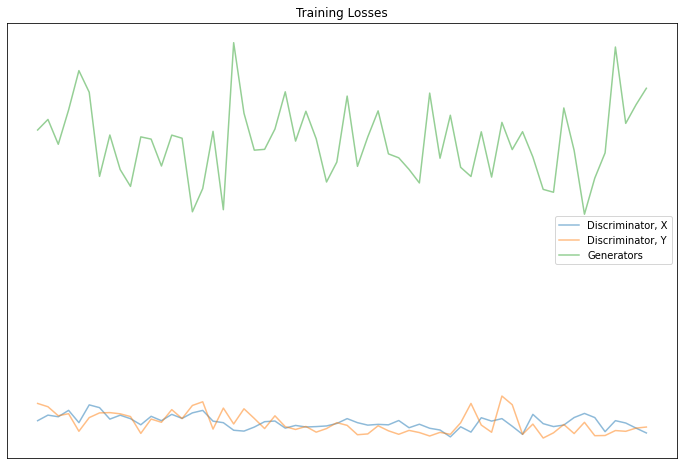

In [19]:
fig, ax = plt.subplots(figsize=(12,8))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator, X', alpha=0.5)
plt.plot(losses.T[1], label='Discriminator, Y', alpha=0.5)
plt.plot(losses.T[2], label='Generators', alpha=0.5)
plt.title("Training Losses")
plt.legend()

## 6. Visualize the Results 

### (Optional) Load Pretrained Models

If we lack the time and resources to fully train the model, we can load a pretrained model and visualize the results. Use the ```save_samples``` function as in the training loop

In [ ]:
from helpers import load_checkpoints
load_checkpoints(G_XtoY, G_YtoX, D_X, D_Y, checkpoint_dir='checkpoints_cyclegan')

### Visualize Samples 

In [20]:
import matplotlib.image as mpimg

# helper visualization code
def view_samples(iteration, sample_dir='samples_cyclegan'):
    
    # samples are named by iteration
    path_XtoY = os.path.join(sample_dir, 'sample-{:06d}-X-Y.png'.format(iteration))
    path_YtoX = os.path.join(sample_dir, 'sample-{:06d}-Y-X.png'.format(iteration))
    
    # read in those samples
    try: 
        x2y = mpimg.imread(path_XtoY)
        y2x = mpimg.imread(path_YtoX)
    except:
        print('Invalid number of iterations.')
    
    fig, (ax1, ax2) = plt.subplots(figsize=(18,20), nrows=2, ncols=1, sharey=True, sharex=True)
    ax1.imshow(x2y)
    ax1.set_title('X to Y')
    ax2.imshow(y2x)
    ax2.set_title('Y to X')

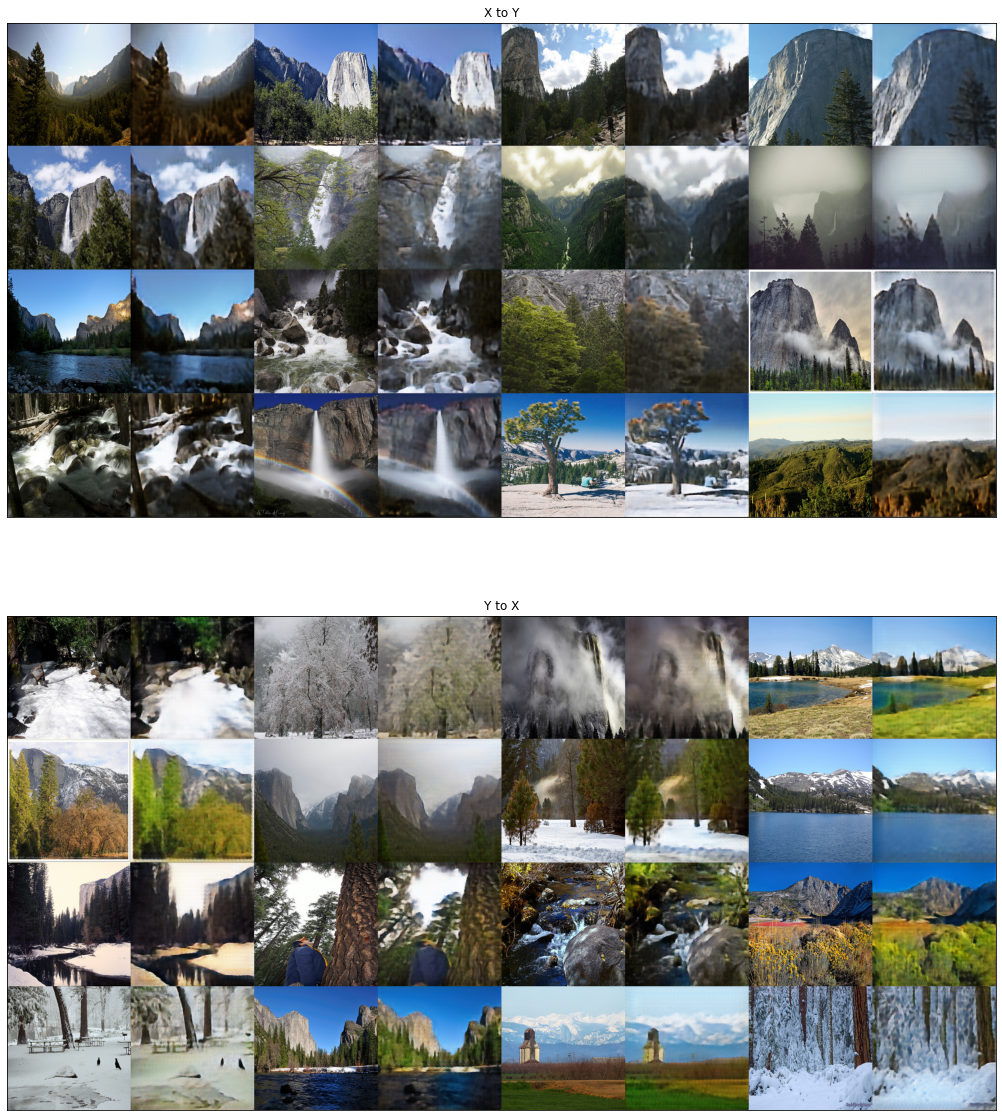

In [21]:
# view samples at iteration 6000
view_samples(6000, 'samples_cyclegan')

In [ ]:
view_samples(1000, 'samples_cyclegan')